# Changes to model timesteps

It is not uncommon for the CAFE model to become unstable during a run. For most of the CAFE-f6 forecasts, the standard approach for resolving this issue was to restart the forecast with reduced model timesteps. There are three timesteps used by CAFE:

```
dt_atmos   <- the atmospheric component time step [s]
dt_ocean   <- the ocean component time step [s]
dt_cpld    <- the coupling time step [s]
```

Most CAFE-f6 runs use the default values of `dt_atmos = 1800, dt_ocean = 1800, dt_cpld = 1800` (see https://github.com/csiro-dcfp/cm-forecasts/blob/ccf838e5d1ac7f71c63cda6a43e5eee5280fff4c/settings.sh#L116). However, some runs that fell over were rerun with `dt_atmos = 1200, dt_ocean = 1200, dt_cpld = 1200` or even `dt_atmos = 900, dt_ocean = 900, dt_cpld = 900` if that was also unsuccessful.

It was subsequently discovered that adjusting `dt_atmos` can substantially effect the free-running attractor of the model, see https://github.com/dougiesquire/cm-historical/blob/0d7c4601592b5b337d77f3c04228f1a0f67d76c2/notebooks/hist_mem001.ipynb. This is very evident in the forecast members that were run with a reduced atmospheric time step:

In [1]:
import xarray as xr

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12

In [3]:
data_dir = "../data/raw/CAFEf6/c5-d60-pX-f6-20201101/"
file = f"{data_dir}/atmos_isobaric_month.zarr.zip"

ds = xr.open_zarr(
    f"{data_dir}/atmos_isobaric_month.zarr.zip",
)["t_surf"]

ds_gbl = ds.weighted(ds["area"]).mean(["lat", "lon"]).compute()

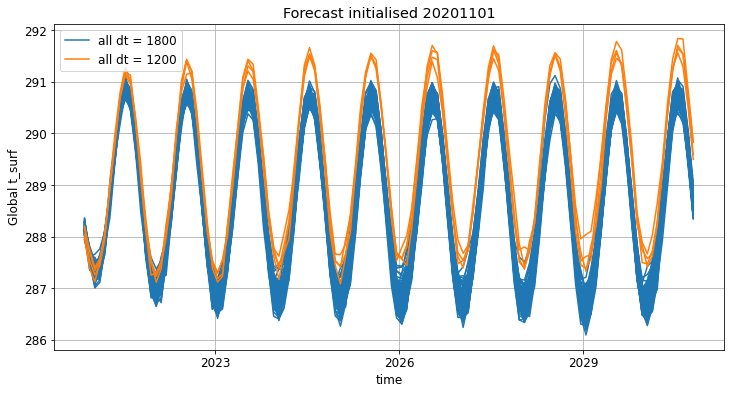

In [4]:
reduced_dt_ensembles = [27, 37, 51, 76]
ds_reduced_dt = ds_gbl.sel(ensemble=reduced_dt_ensembles)
ds_default_dt = ds_gbl.sel(
    ensemble=list(set(ds_gbl.ensemble.values) - set(reduced_dt_ensembles))
)

p0 = ds_default_dt.plot.line(x="time", add_legend=False, color="C0")
p1 = ds_reduced_dt.plot.line(x="time", add_legend=False, color="C1")
plt.ylabel(f"Global {ds_default_dt.name}")
plt.grid()
plt.title(f"Forecast initialised {data_dir.split('/')[-2][-8:]}")
_ = plt.legend([p0[0], p1[0]], ["all dt = 1800", "all dt = 1200"])

## Masking based on timestep

I've generated a mask for the forecasts that were run at a reduced timestep so that these forecasts can be readily removed from analysis. 

The total number of forecasts run with reduce dt_atmos is 172, which is 2.2395833333333335% of the CAFE-f6 dataset


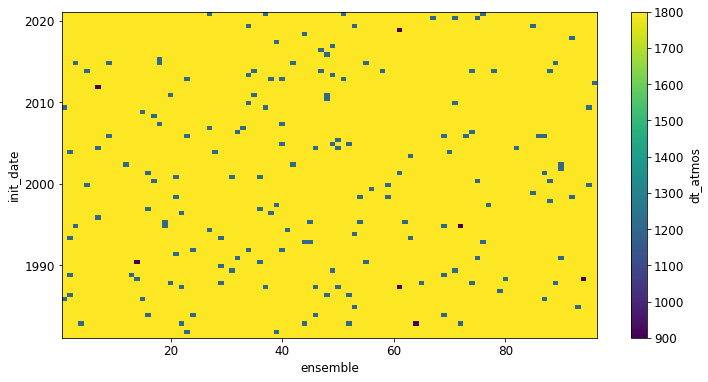

In [5]:
dt_mask = xr.open_dataset("../data/raw/CAFEf6/CAFE-f6_dt_atmos.nc")["dt_atmos"]
dt_mask.plot()

reduced_dt = xr.where(dt_mask < 1800, 1, 0)
print(
    (
        f"The total number of forecasts run with reduce dt_atmos is {reduced_dt.sum().values},"
        f" which is {100 * reduced_dt.mean().values}% of the CAFE-f6 dataset"
    )
)

Note that moving forward, I've found that users can change `dt_ocean` without (obviously) effecting the free-running attractor of CAFE (see https://github.com/dougiesquire/cm-historical/blob/0d7c4601592b5b337d77f3c04228f1a0f67d76c2/notebooks/hist_mem001.ipynb). All forecasts run since that became unstable were rerun with `dt_atmos = 1800, dt_ocean = 900, dt_cpld = 1800`.